In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 43.1MB/s]
Archive:  raman-spectroscopy-of-diabetes.zip
  inflating: AGEs.csv                
  inflating: earLobe.csv             
  inflating: innerArm.csv            
  inflating: thumbNail.csv           
  inflating: vein.csv                


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


thumbNail:
[[-0.32744804 -6.98120707]
 [-0.01423959  1.0974604 ]
 [-0.69867891 -6.321904  ]
 [ 0.07861507  5.37661286]
 [ 0.0843422   4.2324475 ]]

innerArm:
[[ -0.85674614 -20.34400829]
 [ -0.71012781 -11.88714027]
 [ -2.16372783 -43.58164441]
 [ -0.60815736  -8.13172286]
 [ -0.26572471  -4.01164959]]



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


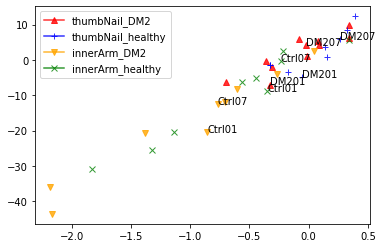

In [2]:
import pandas as pd
import numpy as np
# 可視化用にインポート
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_decomposition import CCA

# データの準備
!kaggle datasets download -d \
codina/raman-spectroscopy-of-diabetes
!unzip raman-spectroscopy-of-diabetes.zip

# 特徴量(thumbNail, innerArm)
# 親指の爪(thumbNail)のデータを読み込む
df_thumb = pd.read_csv('thumbNail.csv', header=[0])
# 糖尿病患者のデータだけに絞り込む（'has_DM2'が1）
df_thumb_hasDM2 = df_thumb.query('has_DM2 == "1"')
# 糖尿病患者のIDのリストを作成
patient_IDs = df_thumb_hasDM2['patientID'].values
df_thumb_hasDM2.drop(['patientID', 'has_DM2'], \
                     axis=1, inplace=True)

# 健常者のデータだけに絞り込む（'has_DM2'が0）
df_thumb_healthy = df_thumb.query('has_DM2 == "0"')
# 健常者のIDのリストを作成
healthy_IDs = df_thumb_healthy['patientID'].values
df_thumb_healthy.drop(['patientID', 'has_DM2'], \
                     axis=1, inplace=True)
df_thumb.drop(['patientID', 'has_DM2'], axis=1, inplace=True)

# 内腕(innerArm)のデータを読み込む
df_arm = pd.read_csv('innerArm.csv', header=[0])
df_arm_hasDM2 = df_arm.query('has_DM2 == "1"')
df_arm_hasDM2.drop(['patientID', 'has_DM2'], \
                   axis=1, inplace=True)
df_arm_healthy = df_arm.query('has_DM2 == "0"')
df_arm_healthy.drop(['patientID', 'has_DM2'], \
                    axis=1, inplace=True)
df_arm.drop(['patientID', 'has_DM2'], axis=1, inplace=True)

# CCAクラスのインスタンス生成
# 2次元に変換するため、n_componentsに2を設定
cca = CCA(n_components=2)
# 特徴量ベクトルをnumpy形式に変換する
t = np.array(df_thumb.values)
a = np.array(df_arm.values)
t1 = np.array(df_thumb_hasDM2.values)
a1 = np.array(df_arm_hasDM2.values)
t2 = np.array(df_thumb_healthy.values)
a2 = np.array(df_arm_healthy.values)

# CCAを実行
cca.fit(t, a)
t1_c = cca.transform(t1)
a1_c = cca.transform(a1)
t2_c = cca.transform(t2) 
a2_c = cca.transform(a2)

# 2次元特徴量を可視化
def makeGraph(type, data, texts, legends, colors, markers):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for n, d in enumerate(data):
        for i, (dim1,dim2,id) in enumerate( \
                 zip(d[:,0], d[:,1], texts[n]) ):
            if i == 0:
                ax.plot(dim1, dim2, c=colors[n],\
                        marker=markers[n], alpha=0.8, \
                        label=legends[n])
            else:
                ax.plot(dim1, dim2, c=colors[n],\
                        marker=markers[n], alpha=0.8)
            if i % 6 == 0:
                ax.annotate(id,(dim1,dim2))
    ax.legend(loc=0)
    plt.savefig('CCA_plot_{}.png'.format(type), dpi=500)
    plt.show()
    
print('thumbNail:\n{}\n'.format(t1_c[:5]))
print('innerArm:\n{}\n'.format(a1_c[:5]))
legends = ['thumbNail_DM2', 'thumbNail_healthy', 
           'innerArm_DM2', 'innerArm_healthy']
colors = ['red', 'blue', 'orange', 'green'] 
markers = ['^', '+', 'v', 'x'] 
ids = [patient_IDs, healthy_IDs]
makeGraph('DM2_and_healthy', [t1_c, t2_c, a1_c, a2_c],
          np.repeat(ids, 2, axis=0), \
          legends, colors, markers)


